In [115]:
import getpass
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
password = getpass.getpass()

········


Create a query or queries to extract the information you think may be relevant for building the prediction model. 
It should include some film features and some rental features. 
Use the data from 2005.

In [116]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''select f.film_id, f.title, f.rental_rate, i.inventory_id, r.rental_id, r.rental_date
from film f
left join inventory i
on f.film_id = i.film_id
left join rental r
on i.inventory_id = r.inventory_id;'''

data = pd.read_sql_query(query, engine)
data.head(5)

,film_id,title,rental_rate,inventory_id,rental_id,rental_date
0,1,ACADEMY DINOSAUR,0.99,1.0,4863.0,2005-07-08 19:03:15
1,1,ACADEMY DINOSAUR,0.99,1.0,11433.0,2005-08-02 20:13:10
2,1,ACADEMY DINOSAUR,0.99,1.0,14714.0,2005-08-21 21:27:43
3,1,ACADEMY DINOSAUR,0.99,1.0,16050.0,2022-08-01 11:50:21
4,1,ACADEMY DINOSAUR,0.99,2.0,972.0,2005-05-30 20:21:07


Create a query to get the total amount of rentals in June for each film.

In [117]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''select f.film_id,f.title, count(f.film_id) as june_counts
from film f
left join inventory i
on f.film_id = i.film_id
left join rental r
on i.inventory_id = r.inventory_id
where rental_date like '2005-06%%'
group by f.film_id, f.title;'''

june_count = pd.read_sql_query(query, engine)
june_count.head(5)

,film_id,title,june_counts
0,356,GIANT TROOPERS,4
1,961,WASH HEAVENLY,5
2,614,NAME DETECTIVE,4
3,369,GOODFELLAS SALUTE,5
4,220,DEER VIRGINIAN,4


Do the same with July.

In [118]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''select f.film_id,f.title, count(f.film_id) as july_counts
from film f
left join inventory i
on f.film_id = i.film_id
left join rental r
on i.inventory_id = r.inventory_id
where rental_date like '2005-07%%'
group by f.film_id, f.title;'''

july_count = pd.read_sql_query(query, engine)
july_count.head(5)

,film_id,title,july_counts
0,194,CROW GREASE,7
1,376,GRAPES FURY,11
2,184,CORE SUIT,9
3,600,MOTIONS DETAILS,5
4,19,AMADEUS HOLY,8


Create a new column containing (Yes/No) for each film,
whether or not the number of monthly rentals in July was bigger than in June. 
Your objective will be to predict this new column.

In [119]:
#Joining both months and using number of returned orders to count
#june_july_count will be my main table

In [120]:
june_july_count = pd.merge(left = june_count,
                                 right = july_count,
                                 how = 'inner',
                                 left_on = "title", 
                                 right_on= "title") 

june_july_count.head()

,film_id_x,title,june_counts,film_id_y,july_counts
0,356,GIANT TROOPERS,4,356,11
1,961,WASH HEAVENLY,5,961,7
2,614,NAME DETECTIVE,4,614,11
3,369,GOODFELLAS SALUTE,5,369,13
4,220,DEER VIRGINIAN,4,220,13


In [121]:
#Now droping film_id_y because is same value as film_id_x

In [122]:
june_july_count=june_july_count.drop("film_id_y", axis=1)

In [123]:
june_july_count

,film_id_x,title,june_counts,july_counts
0,356,GIANT TROOPERS,4,11
1,961,WASH HEAVENLY,5,7
2,614,NAME DETECTIVE,4,11
3,369,GOODFELLAS SALUTE,5,13
4,220,DEER VIRGINIAN,4,13
...,...,...,...,...
895,601,MOULIN WAKE,1,8
896,519,LIBERTY MAGNIFICENT,1,3
897,47,BABY HALL,1,3
898,248,DOZEN LION,1,2


In [124]:
#starting to predict which months had more yes

In [125]:
june_july_count['july&june']= june_july_count['july_counts']>june_july_count['june_counts']
june_july_count
june_july_count[['july&june']].value_counts()

july&june
True         894
False          6
dtype: int64

In [126]:
#Creating Y/N column

june_july_count =june_july_count.replace({'july&june': {True: 'Yes', False:'No'}})
june_july_count

,film_id_x,title,june_counts,july_counts,july&june
0,356,GIANT TROOPERS,4,11,Yes
1,961,WASH HEAVENLY,5,7,Yes
2,614,NAME DETECTIVE,4,11,Yes
3,369,GOODFELLAS SALUTE,5,13,Yes
4,220,DEER VIRGINIAN,4,13,Yes
...,...,...,...,...,...
895,601,MOULIN WAKE,1,8,Yes
896,519,LIBERTY MAGNIFICENT,1,3,Yes
897,47,BABY HALL,1,3,Yes
898,248,DOZEN LION,1,2,Yes


In [127]:
june_july_count[['july&june']].value_counts()

july&june
Yes          894
No             6
dtype: int64

Analyze extracted features and transform them. 
You may need to encode some categorical variables or scale numerical variables.

In [128]:
#Starting to transform data

In [129]:
june_july_count.head()

,film_id_x,title,june_counts,july_counts,july&june
0,356,GIANT TROOPERS,4,11,Yes
1,961,WASH HEAVENLY,5,7,Yes
2,614,NAME DETECTIVE,4,11,Yes
3,369,GOODFELLAS SALUTE,5,13,Yes
4,220,DEER VIRGINIAN,4,13,Yes


In [130]:
#X-y Split

y = june_july_count['july&june']
X = june_july_count.drop(['july&june'], axis=1)

In [131]:
display(X.head())
display(y.head())

,film_id_x,title,june_counts,july_counts
0,356,GIANT TROOPERS,4,11
1,961,WASH HEAVENLY,5,7
2,614,NAME DETECTIVE,4,11
3,369,GOODFELLAS SALUTE,5,13
4,220,DEER VIRGINIAN,4,13


0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: july&june, dtype: object

In [132]:
X_num = X.select_dtypes(include = np.number)
X_cat = X.select_dtypes(include = np.object)
display(X_num.head(4))
display(X_cat.head(4))

C:\Users\JoãoCabral\AppData\Local\Temp\ipykernel_10728\2460519903.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_cat = X.select_dtypes(include = np.object)


,film_id_x,june_counts,july_counts
0,356,4,11
1,961,5,7
2,614,4,11
3,369,5,13


,title
0,GIANT TROOPERS
1,WASH HEAVENLY
2,NAME DETECTIVE
3,GOODFELLAS SALUTE


In [133]:
#encoding Categorial variables

encoder = OneHotEncoder(drop='first')
encoder.fit(X_cat)
X_cat_encoded = encoder.transform(X_cat).toarray()
cols = encoder.get_feature_names(input_features=X_cat.columns)
X_cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=cols)

X_cat_encoded_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALADDIN CALENDAR,title_ALAMO VIDEOTAPE,title_ALASKA PHANTOM,title_ALIEN CENTER,...,title_WORST BANGER,title_WRATH MILE,title_WRONG BEHAVIOR,title_WYOMING STORM,title_YENTL IDAHO,title_YOUNG LANGUAGE,title_YOUTH KICK,title_ZHIVAGO CORE,title_ZOOLANDER FICTION,title_ZORRO ARK
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
#concating categoricals and now we have all in numbers
X_num_cat = pd.concat([ X_num,X_cat_encoded_df], axis=1)
X_num_cat.head()

,film_id_x,june_counts,july_counts,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALADDIN CALENDAR,...,title_WORST BANGER,title_WRATH MILE,title_WRONG BEHAVIOR,title_WYOMING STORM,title_YENTL IDAHO,title_YOUNG LANGUAGE,title_YOUTH KICK,title_ZHIVAGO CORE,title_ZOOLANDER FICTION,title_ZORRO ARK
0,356,4,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,961,5,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,614,4,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,369,5,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,220,4,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
#transforming data

transformer = MinMaxScaler().fit(X_num_cat)
X_num_cat_norm = transformer.transform(X_num_cat)
X_num_cat_norm_df = pd.DataFrame(X_num_cat_norm, columns=X_num_cat.columns)

In [136]:
display(X_num_cat_norm)

array([[0.35535536, 0.5       , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.96096096, 0.66666667, 0.4       , ..., 0.        , 0.        ,
        0.        ],
       [0.61361361, 0.5       , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04604605, 0.        , 0.13333333, ..., 0.        , 0.        ,
        0.        ],
       [0.24724725, 0.        , 0.06666667, ..., 0.        , 0.        ,
        0.        ],
       [0.19319319, 0.        , 0.4       , ..., 0.        , 0.        ,
        0.        ]])

In [137]:
print(X_num_cat_norm.shape)

(900, 902)


In [138]:
X_num_cat_norm_df

,film_id_x,june_counts,july_counts,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALADDIN CALENDAR,...,title_WORST BANGER,title_WRATH MILE,title_WRONG BEHAVIOR,title_WYOMING STORM,title_YENTL IDAHO,title_YOUNG LANGUAGE,title_YOUTH KICK,title_ZHIVAGO CORE,title_ZOOLANDER FICTION,title_ZORRO ARK
0,0.355355,0.500000,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960961,0.666667,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.613614,0.500000,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.368368,0.666667,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.219219,0.500000,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.600601,0.000000,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,0.518519,0.000000,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.046046,0.000000,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,0.247247,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


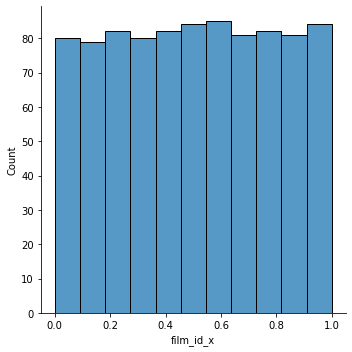

In [139]:
sns.displot(X_num_cat_norm_df['film_id_x']) #Plot with data transformed
plt.show()

Create a logistic regression model to predict this new column from the cleaned data.

In [140]:
#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X_num_cat_norm_df, y, test_size=0.2, random_state=42)

X_train.head()

,film_id_x,june_counts,july_counts,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALADDIN CALENDAR,...,title_WORST BANGER,title_WRATH MILE,title_WRONG BEHAVIOR,title_WYOMING STORM,title_YENTL IDAHO,title_YOUNG LANGUAGE,title_YOUTH KICK,title_ZHIVAGO CORE,title_ZOOLANDER FICTION,title_ZORRO ARK
10,0.951952,0.166667,0.266667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
334,0.079079,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.918919,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
678,0.837838,0.833333,0.733333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,0.066066,0.166667,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
X_test.head()

,film_id_x,june_counts,july_counts,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALADDIN CALENDAR,...,title_WORST BANGER,title_WRATH MILE,title_WRONG BEHAVIOR,title_WYOMING STORM,title_YENTL IDAHO,title_YOUNG LANGUAGE,title_YOUTH KICK,title_ZHIVAGO CORE,title_ZOOLANDER FICTION,title_ZORRO ARK
70,0.657658,0.333333,0.266667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
827,0.579580,0.166667,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231,0.268268,0.166667,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,0.842843,0.333333,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.251251,0.500000,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
y_test.head()

70     Yes
827    Yes
231    Yes
588    Yes
39     Yes
Name: july&june, dtype: object

In [143]:
#Creating logistic regression model

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr')


classification.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0)

In [144]:
#Predictions!

y_train_pred = classification.predict(X_train)
print("Train Predictions",y_train_pred[:10])
classification.score(X_train, y_train)

Train Predictions ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes']


0.9944444444444445

In [145]:
y_test_pred = classification.predict(X_test)
print("Test Predictions",y_test_pred[:10])
classification.score(X_test, y_test)

Test Predictions ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes']


0.9888888888888889

Evaluate the results.

In [ ]:
#I have learned so much from this lab!!
# + prediction model is correct clients will rent more in July then June